### http://localhost:8888/notebooks/Documents/Sem03/NLP/project2/Project%202-Version-2-preprocessing%20%26%20clasifier.ipynb

### Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import cv2
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision
from torch.utils.data import random_split 
from torchvision import utils
import itertools 					   
import torchvision.transforms as transforms							  
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn					 
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report		 
from tqdm.notebook import trange, tqdm
from torch import optim
from time import strftime
import itertools
import random
from os import walk
from os.path import join
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout
import warnings
warnings.filterwarnings('ignore')

### Path

In [32]:
METADATA_PATH = (r'metadata.csv')
TUMOR_IMG_PATH = (r'Brain Tumor/')
HEALTHY_IMG_PATH = (r'Healthy/')
CLASS_TUMOR = 1
CLASS_HEALTHY = 0
NOISE_FLOOR = 10;
WHITE_THRE = 30;
BLACK_THRE = 1;
TARGET_SIZE = 64;
TOTAL_INPUTS = TARGET_SIZE ** 2

In [33]:
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df.shape

(4600, 6)

In [34]:
metadata_df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


### Explore single images

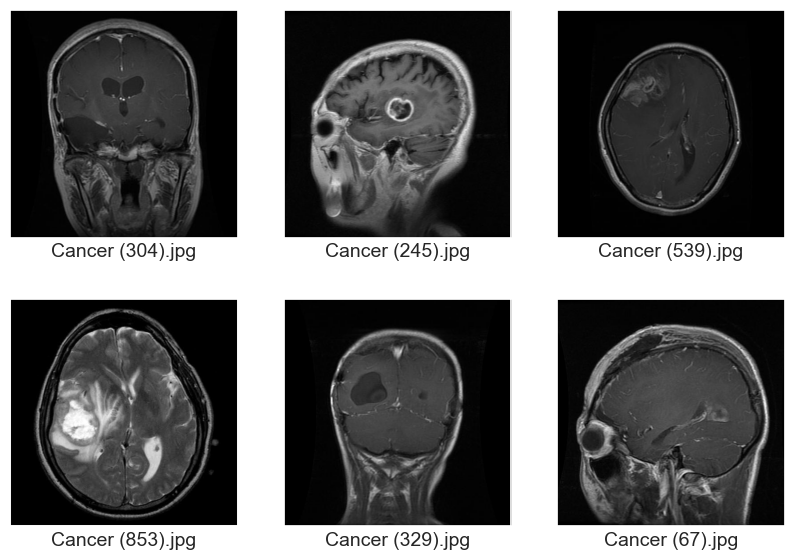

In [35]:
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')
for i in range(1, 7):
    plt.subplot(2, 3, i)
    rand_pick = random.randint(1, 1000)
    random_img = str(rand_pick)
    img = mpimg.imread(TUMOR_IMG_PATH + 'Cancer (' + random_img + ').jpg')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Cancer (' + str(random_img) + ').jpg', fontsize=14)
fig.subplots_adjust(hspace=-0.4)
plt.show()

## Preprocessing and cleaning the dataset

### Testing the preprocesss sequence on a single image

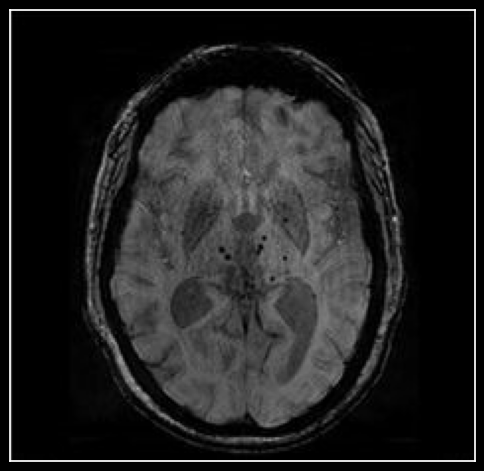

In [36]:
EXAMPLE_IMG_PATH = HEALTHY_IMG_PATH + "Not Cancer  (122).jpg"
img1 = mpimg.imread(EXAMPLE_IMG_PATH)
fig = plt.figure(figsize=[6,6])
fig.patch.set_facecolor('black')
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.show()

In [37]:
def rgb2gray(rgb_img):
    if rgb_img.ndim == 3:
        R, G, B = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
        output_img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    else:
       output_img = rgb_img
    if output_img.max() < 1.1:
        output_img = output_img * 255
    return output_img

In [38]:
print(f"Shape before: {img1.shape}")

Shape before: (228, 235, 3)


In [39]:
img2 = rgb2gray(img1)
print(f"Shape after: {img2.shape}")

Shape after: (228, 235)


In [40]:
def reduce_noise(noisy_img, noise_floor=NOISE_FLOOR):
    clean_img = np.array(noisy_img)
    clean_img[noisy_img < NOISE_FLOOR] = 0
    return clean_img

In [41]:
print("Top left corner before:")
img2[:6, :6]

Top left corner before:


array([[109.989 ,  31.9968,  33.9966,  36.9963,  35.9964,  34.9965],
       [ 77.9922,   0.    ,   1.9998,   4.9995,   2.9997,   2.9997],
       [ 76.9923,   0.    ,   0.    ,   2.9997,   0.9999,   0.    ],
       [ 81.9918,   3.9996,   4.9995,   6.9993,   3.9996,   3.9996],
       [ 78.9921,   0.    ,   0.    ,   1.9998,   0.    ,   0.    ],
       [ 80.9919,   1.9998,   0.9999,   2.9997,   0.    ,   0.    ]])

In [42]:
img3 = reduce_noise(img2)
print("Top left corner after:")
img3[:6, :6]

Top left corner after:


array([[109.989 ,  31.9968,  33.9966,  36.9963,  35.9964,  34.9965],
       [ 77.9922,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 76.9923,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 81.9918,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 78.9921,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 80.9919,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ]])

In [43]:
def remove_white_borders(img_with_borders, threshold=WHITE_THRE):
    # left
    if np.mean(img_with_borders[:, 0]) > threshold:
        img_with_borders[:, 0] = 0;
    # right
    if np.mean(img_with_borders[:, -1]) > threshold:
        img_with_borders[:, -1] = 0;
    # top
    if np.mean(img_with_borders[0, :]) > threshold:
        img_with_borders[0, :] = 0;
    # bottom
    if np.mean(img_with_borders[-1, :]) > threshold:
        img_with_borders[-1, :] = 0;
    return img_with_borders

In [44]:
print("Top left corner before:")
img3[:6, :6]

Top left corner before:


array([[109.989 ,  31.9968,  33.9966,  36.9963,  35.9964,  34.9965],
       [ 77.9922,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 76.9923,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 81.9918,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 78.9921,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 80.9919,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ]])

In [45]:
img4 = remove_white_borders(img3)
print("Top left corner after:")
img4[:6, :6]

Top left corner after:


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [46]:
def remove_black_padding(img_with_padding, threshold=BLACK_THRE):
    # Sides
    vert_mean = np.mean(img_with_padding, axis=0)
    vert_map = vert_mean > BLACK_THRE;
    vert_matches = np.where(vert_map == True)
    img_no_padding = img_with_padding[:, vert_matches[0][0]:vert_matches[0][-1]]
    # Top & bottom
    hori_mean = np.mean(img_no_padding, axis=1)
    hori_map = hori_mean > BLACK_THRE;
    hori_matches = np.where(hori_map == True)
    img_no_padding = img_no_padding[hori_matches[0][0]:hori_matches[0][-1], :]
    return img_no_padding

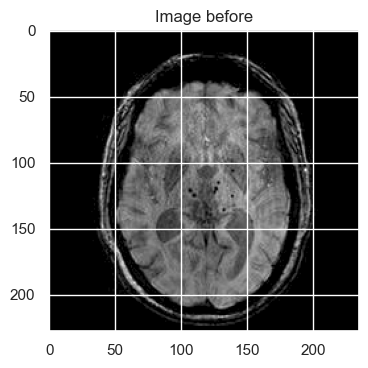

In [47]:
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.title("Image before")
plt.imshow(img4, cmap="gray")
plt.show()

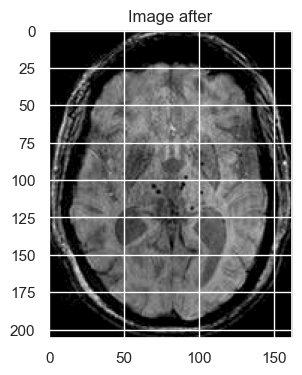

In [48]:
img5 = remove_black_padding(img4)
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.title("Image after")
plt.imshow(img5, cmap="gray")
plt.show()

In [49]:
def square_image(rect_img):
    X, Y = rect_img.shape
    if X != Y:
        if X > Y:
            out_img = np.zeros((X, X))
            offset = int(np.ceil((X-Y) / 2))
            out_img[:, offset : (offset + Y)] = rect_img
        else:
            out_img = np.zeros((Y, Y))
            offset = int(np.ceil((Y-X) / 2))
            out_img[offset : (offset + X), :] = rect_img
        return out_img
    else:
        return rect_img

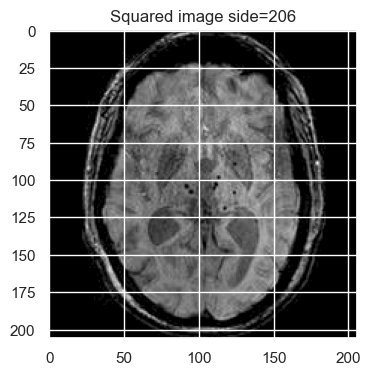

In [50]:
img6 = square_image(img5)
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.imshow(img6, cmap="gray")
plt.title(f"Squared image side={img6.shape[0]}")
plt.show()

In [56]:
img7 = cv2.resize(img6, dsize=(TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_CUBIC)

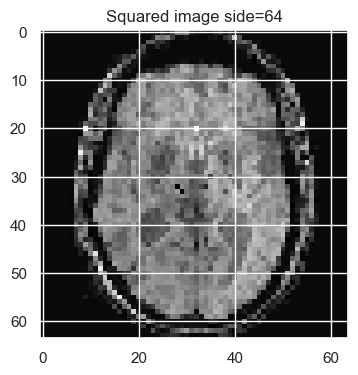

In [57]:
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.imshow(img7, cmap="gray")
plt.title(f"Squared image side={img7.shape[0]}")
plt.show()

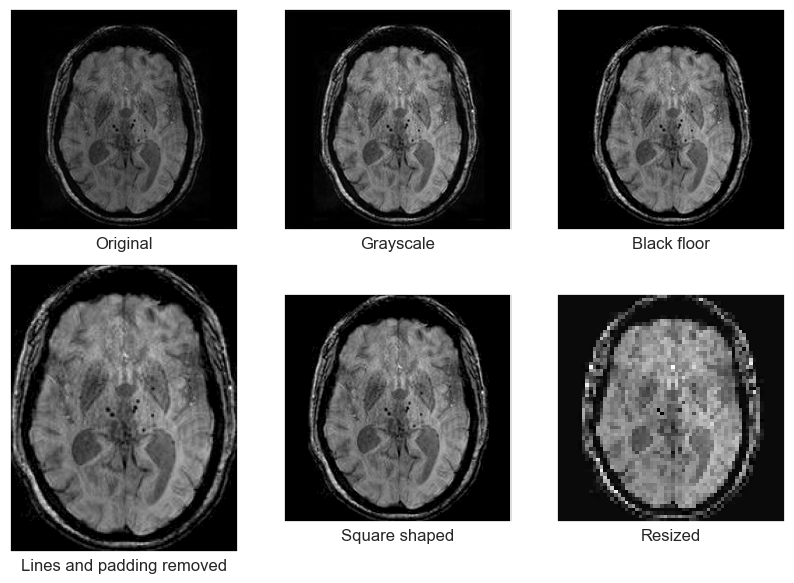

In [58]:
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')
plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.xlabel("Original")

plt.subplot(2, 3, 2)
plt.imshow(img2, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Grayscale")

plt.subplot(2, 3, 3)
plt.imshow(img3, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Black floor")

plt.subplot(2, 3, 4)
plt.imshow(img5, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Lines and padding removed")

plt.subplot(2, 3, 5)
plt.imshow(img6, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Square shaped")

plt.subplot(2, 3, 6)
plt.imshow(img7, cmap="gray")
plt.xlabel("Resized")
plt.xticks([])
plt.yticks([])
fig.subplots_adjust(hspace=-0.4)
plt.show()

In [59]:
def preprocesss_img(input_img):
    output_img = rgb2gray(input_img)
    output_img = reduce_noise(output_img)
    output_img = remove_white_borders(output_img)
    output_img = remove_black_padding(output_img)
    output_img = square_image(output_img)
    output_img = cv2.resize(output_img, dsize=(TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
    return output_img

In [60]:
features = np.zeros((1, TARGET_SIZE ** 2))
target = np.array([])
debug=1
# Fill with tumor images
for root, dirnames, filenames in walk(TUMOR_IMG_PATH):
    n_total = len(filenames)
    n = 1
    for filename in filenames:
        file_path = join(root, filename)
        if n % 200 == 0:
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1        
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        features = np.vstack([features, np.reshape(img, -1)])
        target = np.append(target, CLASS_TUMOR)
features = features[1:, :] # Removing the first zeros row

File 200/2513	 Cancer (1174).JPG
File 400/2513	 Cancer (1352).jpg
File 600/2513	 Cancer (1530).jpg
File 800/2513	 Cancer (1709).jpg
File 1000/2513	 Cancer (1889).jpg
File 1200/2513	 Cancer (2065).jpg
File 1400/2513	 Cancer (2243).jpg
File 1600/2513	 Cancer (2421).jpg
File 1800/2513	 Cancer (401).jpg
File 2000/2513	 Cancer (567).jpg
File 2200/2513	 Cancer (73).tif
File 2400/2513	 Cancer (898).jpg


In [61]:
# Fill with healthy images
for root, dirnames, filenames in walk(HEALTHY_IMG_PATH):
    n_total = len(filenames)
    n = 1
    for filename in filenames:
        file_path = join(root, filename)
        if n % 200 == 0:
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1        
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        features = np.vstack([features, np.reshape(img, -1)])
        target = np.append(target, CLASS_HEALTHY)

File 200/2087	 Not Cancer  (1176).jpg
File 400/2087	 Not Cancer  (1356).jpg
File 600/2087	 Not Cancer  (1536).jpg
File 800/2087	 Not Cancer  (1716).jpg
File 1000/2087	 Not Cancer  (1897).jpg
File 1200/2087	 Not Cancer  (2075).jpg
File 1400/2087	 Not Cancer  (382).jpg
File 1600/2087	 Not Cancer  (560).JPG
File 1800/2087	 Not Cancer  (74).jpg
File 2000/2087	 Not Cancer  (92).jpg


In [62]:
df = pd.DataFrame(features)
df["target"] = target

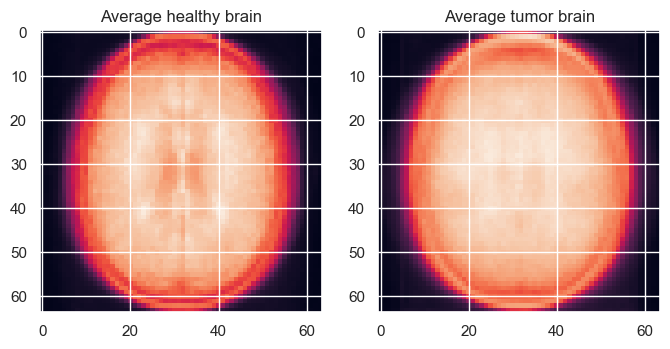

In [63]:
average_healthy_brain = np.array(df[df["target"] == CLASS_HEALTHY].drop("target", axis=1).mean()).reshape(64,64)
average_tumor_brain = np.array(df[df["target"] == CLASS_TUMOR].drop("target", axis=1).mean()).reshape(64,64)
plt.figure(figsize=[8, 4])
plt.subplot(1,2,1)
plt.imshow(average_healthy_brain)
plt.title('Average healthy brain')
plt.subplot(1,2,2)
plt.imshow(average_tumor_brain)
plt.title('Average tumor brain')
plt.show()

In [64]:
target = df["target"]
features = df.drop("target", axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=10)

In [65]:
# validation dataset
VALIDATION_SIZE = 600
x_val = x_train[:VALIDATION_SIZE]
y_val = y_train[:VALIDATION_SIZE]

In [66]:
model_1 = Sequential([
    Dense(units=256, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=128, activation='relu', name='m1_hidden2'),
    Dense(units=64, activation='relu', name='m1_hidden3'),
    Dense(units=16, activation='relu', name='m1_hidden4'),
    Dense(units=2, activation='softmax', name='m1_output')
])
asdf = tf.keras.optimizers.Adam
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 256)               1048832   
                                                                 
 m1_hidden2 (Dense)          (None, 128)               32896     
                                                                 
 m1_hidden3 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden4 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 2)                 34        
                                                                 
Total params: 1091058 (4.16 MB)
Trainable params: 1091058 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
samples_per_batch = 100
n_epochs = 60
# logdir = LOG_DIR + f"model_1 at {strftime('%H:%M:%S')}"
# tb_train_dir = logdir + "/train"

In [69]:
model_1.fit(x=x_train, y=y_train, 
            epochs=n_epochs, 
            batch_size=samples_per_batch, 
            validation_data=(x_val, y_val))

Epoch 1/60


42/42 [==============================] - 2s 15ms/step - loss: 17.2116 - accuracy: 0.5715 - val_loss: 1.8818 - val_accuracy: 0.6600
Epoch 2/60
42/42 [==============================] - 0s 10ms/step - loss: 2.8747 - accuracy: 0.6365 - val_loss: 1.5491 - val_accuracy: 0.7133
Epoch 3/60
42/42 [==============================] - 0s 11ms/step - loss: 1.0146 - accuracy: 0.7461 - val_loss: 0.8393 - val_accuracy: 0.7617
Epoch 4/60
42/42 [==============================] - 0s 10ms/step - loss: 1.0735 - accuracy: 0.7225 - val_loss: 1.2488 - val_accuracy: 0.7317
Epoch 5/60
42/42 [==============================] - 0s 9ms/step - loss: 0.7532 - accuracy: 0.7857 - val_loss: 0.9893 - val_accuracy: 0.7333
Epoch 6/60
42/42 [==============================] - 0s 10ms/step - loss: 1.3152 - accuracy: 0.7169 - val_loss: 0.6578 - val_accuracy: 0.8300
Epoch 7/60
42/42 [==============================] - 0s 11ms/step - loss: 0.4664 - accuracy: 0.8541 - val_loss: 0.2909 - val_accuracy: 0.9050
Epoch 8/60


42/42 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 56/60
42/42 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 57/60
42/42 [==============================] - 0s 10ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 58/60
42/42 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 59/60
42/42 [==============================] - 0s 10ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 60/60
42/42 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000


### analyze results

In [70]:
test_loss, test_accuracy = model_1.evaluate(x_test, y_test)
print(f"loss: {test_loss:0.3}\t accuracy: {test_accuracy:0.1%}")

15/15 [==============================] - 0s 2ms/step - loss: 0.1933 - accuracy: 0.9652
loss: 0.193	 accuracy: 96.5%


In [71]:
# predict the test dataset
predict_x_test = model_1.predict(x_test) 
classes_x_test = np.argmax(predict_x_test, axis=1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=classes_x_test)

15/15 [==============================] - 0s 2ms/step


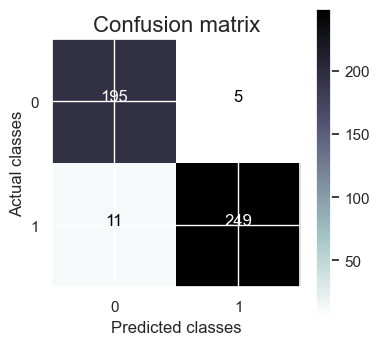

In [72]:
plt.figure(figsize=[4, 4])
plt.imshow(conf_matrix, cmap="bone_r")
plt.title("Confusion matrix", fontsize=16)
plt.ylabel("Actual classes")
plt.xlabel("Predicted classes")
tick_marks = np.arange(2)
plt.yticks(tick_marks, [0,1])
plt.xticks(tick_marks, [0,1])
plt.colorbar()
for i, j in itertools.product(range(2), range(2)):
    plt.text(j, i, conf_matrix[i][j], horizontalalignment="center", 
             color="white" if conf_matrix[i][j] > 100 else "black")
plt.show()

Conclussions¶
Normalizing all the dataset images can greatly simplify the required model to make a classifier. By removing all the unnecessary information from the images and modifying it to adapt to the target acceleration engine the training time is greatly shortened, delivering results in just a few epoches.

## model 2

In [91]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model_2 = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)